<a href="https://colab.research.google.com/github/ColSavage/f1-predicting/blob/main/Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set Up

## Importing F1 Data - File Paths

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rohanrao/formula-1-world-championship-1950-2020")
weatherPath = kagglehub.dataset_download("quantumkaze/f1-weather-dataset-2018-2023")

In [2]:
import pandas as pd

from pathlib import Path

# Creating variables for each csv file

# These variable contain data dated back to 1950
circuits = Path("/root/.cache/kagglehub/datasets/rohanrao/formula-1-world-championship-1950-2020/versions/24/circuits.csv")
#constructor_results = Path("/root/.cache/kagglehub/datasets/rohanrao/formula-1-world-championship-1950-2020/versions/23/constructor_results.csv")
#constructor_standings = Path("/root/.cache/kagglehub/datasets/rohanrao/formula-1-world-championship-1950-2020/versions/23/constructor_standings.csv")
#constructors = Path("/root/.cache/kagglehub/datasets/rohanrao/formula-1-world-championship-1950-2020/versions/23/constructors.csv")
driver_standings = Path("/root/.cache/kagglehub/datasets/rohanrao/formula-1-world-championship-1950-2020/versions/24/driver_standings.csv")
drivers = Path("/root/.cache/kagglehub/datasets/rohanrao/formula-1-world-championship-1950-2020/versions/24/drivers.csv")
lap_times = Path("/root/.cache/kagglehub/datasets/rohanrao/formula-1-world-championship-1950-2020/versions/24/lap_times.csv")
pit_stops = Path("/root/.cache/kagglehub/datasets/rohanrao/formula-1-world-championship-1950-2020/versions/24/pit_stops.csv")
qualifying = Path("/root/.cache/kagglehub/datasets/rohanrao/formula-1-world-championship-1950-2020/versions/24/qualifying.csv")
races = Path("/root/.cache/kagglehub/datasets/rohanrao/formula-1-world-championship-1950-2020/versions/24/races.csv")
results = Path("/root/.cache/kagglehub/datasets/rohanrao/formula-1-world-championship-1950-2020/versions/24/results.csv")
#seasons = Path("/root/.cache/kagglehub/datasets/rohanrao/formula-1-world-championship-1950-2020/versions/23/seasons.csv")
#sprint_results = Path("/root/.cache/kagglehub/datasets/rohanrao/formula-1-world-championship-1950-2020/versions/23/sprint_results.csv")
#status = Path("/root/.cache/kagglehub/datasets/rohanrao/formula-1-world-championship-1950-2020/versions/23/status.csv")

# Weather data for 2018-2023
weather = Path("/root/.cache/kagglehub/datasets/quantumkaze/f1-weather-dataset-2018-2023/versions/1/F1 Weather(2023-2018).csv")


## Data Preprocessing

### Weather and Race Data

In [3]:
# To match the weather data, I will filter all data by year to match with 2018-2023
first_year = 2018
recent_year = 2023

# Filtering races.csv
rdf = pd.read_csv(races)
filtered_races = rdf[(rdf['year'] >= first_year) & (rdf['year'] <= recent_year)]
filtered_races.to_csv('filtered_races.csv', index=False)



In [4]:
# The weather data used has data for every minute of each race. I will take the mean of weather data for each race to allow for better integration with other dataframes.
# In the future, I could divide each race into a fraction of means for a more indepth look and prediction of a race outcome.

# Storing weather data as a dataframe variable
df1 = pd.read_csv(weather)

# Group the weather data by year and the round number. Then calculate the averages of each group's data and reset the new dataframs index for future use.
grouped_weather = df1.groupby(['Year', 'Round Number'])
average_weather = grouped_weather[['AirTemp', 'Humidity', 'Pressure', 'Rainfall', 'TrackTemp', 'WindDirection', 'WindSpeed']].mean().reset_index()
average_weather.to_csv('average_weather.csv', index=False)


In [5]:
# Combine data in to a table that will be useful in Gradient Boost

# Storing each csv as a variable for ease of use during merging.
df1 = pd.read_csv('filtered_races.csv')
df2 = pd.read_csv('average_weather.csv')

# Merging the Filter Race csv with the weather.csv
merged_df = pd.merge(df1, df2, left_on='year', right_on='Year', how='inner')
race_weather = merged_df[merged_df['round'] == merged_df['Round Number']]

# Removing all unnecessary columns from the new dataframe
clean_race_weather = race_weather[['raceId', 'round', 'circuitId', 'name', 'date', 'time', 'AirTemp', 'Humidity', 'Pressure', 'Rainfall', 'TrackTemp', 'WindDirection', 'WindSpeed', 'Year']]

clean_race_weather.to_csv('race_weather.csv', index=False)
# pd.read_csv('race_weather.csv')



### Results data

In [6]:
df1 = pd.read_csv('race_weather.csv')
df2 = pd.read_csv(results)

clean_race_results_weather = pd.merge(df1, df2, left_on='raceId', right_on='raceId', how='inner')
clean_race_results_weather.to_csv('clean_race_results_weather.csv', index=False)

# pd.read_csv('clean_race_results_weather.csv')


### Pit Stop Data

In [7]:
pit_df = pd.read_csv(pit_stops)

# Find the total number of pit stops for each driver in each race
group_pit_stops = pit_df.groupby(['raceId', 'driverId'])
total_pit_stops = group_pit_stops['stop'].count().reset_index()
total_pit_stops.to_csv('total_pit_stops.csv', index=False)

In [8]:
# Find the total time spent pitting for each driver in each race
total_pit_stop_time = group_pit_stops['milliseconds'].sum().reset_index()
total_pit_stop_time.to_csv('total_pit_stop_time.csv', index=False)

In [9]:
# Find the average time for each pit stop for each driver in each race.
average_pit_stop_time = group_pit_stops['milliseconds'].mean().reset_index()
average_pit_stop_time.to_csv('average_pit_stop_time.csv', index=False)

In [10]:
# Combine all processed pit stop data into a new dataframe to then be merged with the main dataframe for the model
combined_pit_stops = pd.merge(total_pit_stops, total_pit_stop_time, left_on=['raceId', 'driverId'], right_on=['raceId', 'driverId'], how='inner')
final_pit_stops = pd.merge(combined_pit_stops, average_pit_stop_time, left_on=['raceId', 'driverId'], right_on=['raceId', 'driverId'], how='inner')

final_pit_stops.columns = ['raceId', 'driverId', 'totalPitStops', 'totalPitTime', 'averagePitTime']

final_pit_stops.to_csv('final_pit_stops.csv', index=False)

clean_race_results_weather = pd.read_csv('clean_race_results_weather.csv')
clean_race_results_weather_pit = pd.merge(clean_race_results_weather, final_pit_stops, left_on=['raceId', 'driverId'], right_on=['raceId', 'driverId'], how='inner')
clean_race_results_weather_pit.to_csv('clean_race_results_weather_pit.csv', index=False)

# pd.read_csv('clean_race_results_weather_pit.csv')

### Lap Time Data

In [11]:
# Gather average lap times, number of pit stops, cu and starting position in Grid based on qualifying

lap_df = pd.read_csv(lap_times)
lap_df['milliseconds'] = lap_df['milliseconds'].fillna(0)
grouped_lap_times = lap_df.groupby(['raceId', 'driverId'])
average_lap_times = grouped_lap_times['milliseconds'].mean().reset_index()


### Circuit and Driver mappings

In [12]:
drivers_df = pd.read_csv(drivers)
circuits_df = pd.read_csv(circuits)

driver_name_lookup = dict(zip(drivers_df['driverId'], drivers_df['forename'] + ' ' + drivers_df['surname']))
circuit_name_lookup = dict(zip(circuits_df['circuitId'], circuits_df['name']))

In [13]:
def get_driver_circuit_names(driver_id, circuit_id):
    """Retrieves driver and circuit names using lookup dictionaries."""
    driver_name = driver_name_lookup.get(driver_id, 'Unknown Driver')
    circuit_name = circuit_name_lookup.get(circuit_id, 'Unknown Circuit')
    return driver_name, circuit_name

### Qualifying

In [14]:
def time_to_milliseconds_new(time_str):
    """Converts a time string in MM:SS.SSS format to milliseconds."""
    # Check if time_str is a string before attempting to split
    if isinstance(time_str, str):
        try:
            m, s = map(float, time_str.split(':'))
            milliseconds = int(60000 * m + 1000 * s)
            return milliseconds
        except ValueError:
            return None  # Handle cases where the format is invalid
    # If time_str is not a string (e.g., float, NaN), return it as is or handle it as needed
    else:
        return time_str  # Or return a default value, e.g., None or 0

In [15]:
qual_df = pd.read_csv(qualifying)

columnsToDrop = ['qualifyId', 'constructorId', 'number', 'position']
qual_df = qual_df.drop(columns=columnsToDrop)

# Convert qualifying times to milliseconds

for col in ['q1', 'q2', 'q3']:
    qual_df[col] = qual_df[col].apply(time_to_milliseconds_new)  # Assuming 'time_to_milliseconds' is defined

grouped_qualifying = qual_df.groupby(['raceId', 'driverId'])[['q1', 'q2', 'q3']].mean().reset_index()
grouped_qualifying['average_qualifying_time'] = grouped_qualifying[['q1', 'q2', 'q3']].mean(axis=1)

grouped_qualifying.drop(columns=['q1', 'q2', 'q3'], inplace=True)

grouped_qualifying.to_csv('grouped_qualifying.csv', index=False)
# pd.read_csv('grouped_qualifying.csv')

# grouped_qualifying.columns

### Final Dataframe

In [16]:
def time_to_milliseconds(time_str):
    """Converts a time string in MM:SS.SSS format to milliseconds."""
    try:
        m, s = map(float, time_str.split(':'))
        milliseconds = int(60000 * m + 1000 * s)
        return milliseconds
    except ValueError:
        return None  # Handle cases where the format is invalid


In [17]:

# Merge the average_lap_times to clean_race_results_weather_pit. This will be all the data needed for the final dataframe.
final_dataframe = pd.merge(clean_race_results_weather_pit, average_lap_times, left_on=['raceId', 'driverId'], right_on=['raceId', 'driverId'], how='inner')
final_dataframe = pd.merge(final_dataframe, grouped_qualifying, left_on=['raceId', 'driverId'], right_on=['raceId', 'driverId'], how='inner')
final_dataframe.rename(columns={'milliseconds_x': 'totalLapTime', 'milliseconds_y': 'averageLapTime'}, inplace=True)

# May want to add 'laps' back. as of the moment, I see no use for number of laps finished if a 'status' column is present.
final_dataframe = final_dataframe.drop(columns=['time_x', 'name', 'number', 'positionText', 'position', 'time_y', 'date', 'fastestLapTime'])
final_dataframe.to_csv('final_dataframe.csv', index=False)
pd.read_csv('final_dataframe.csv')
# final_dataframe.columns

,raceId,round,circuitId,AirTemp,Humidity,Pressure,Rainfall,TrackTemp,WindDirection,WindSpeed,...,totalLapTime,fastestLap,rank,fastestLapSpeed,statusId,totalPitStops,totalPitTime,averagePitTime,averageLapTime,average_qualifying_time
0,989,1,1,24.077477,30.915315,997.003604,0.045045,36.324324,294.126126,3.691892,...,5373283,53,4,220.782,1,1,21787,21787.0,92642.810345,82376.666667
1,989,1,1,24.077477,30.915315,997.003604,0.045045,36.324324,294.126126,3.691892,...,5378319,50,3,220.845,1,1,21821,21821.0,92729.637931,82013.000000
2,989,1,1,24.077477,30.915315,997.003604,0.045045,36.324324,294.126126,3.691892,...,5379592,57,2,221.027,1,1,21421,21421.0,92751.586207,82477.000000
3,989,1,1,24.077477,30.915315,997.003604,0.045045,36.324324,294.126126,3.691892,...,5380352,54,1,222.128,1,1,21440,21440.0,92764.689655,82847.666667
4,989,1,1,24.077477,30.915315,997.003604,0.045045,36.324324,294.126126,3.691892,...,5401169,57,7,219.489,1,1,22573,22573.0,93123.603448,83644.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2227,1120,22,24,26.962821,51.000000,1014.927564,0.000000,33.460897,284.935897,1.794872,...,5310415,43,12,214.626,1,2,44004,22002.0,91558.879310,NaN
2228,1120,22,24,26.962821,51.000000,1014.927564,0.000000,33.460897,284.935897,1.794872,...,5312046,43,13,214.224,1,2,45212,22606.0,91587.000000,85159.000000
2229,1120,22,24,26.962821,51.000000,1014.927564,0.000000,33.460897,284.935897,1.794872,...,\N,42,17,212.534,31,2,42793,21396.5,91419.701754,84738.000000
2230,1120,22,24,26.962821,51.000000,1014.927564,0.000000,33.460897,284.935897,1.794872,...,\N,42,18,211.562,11,1,22665,22665.0,91842.719298,84788.000000


# The Model

In [18]:
!pip install xgboost==2.1.3
!pip install shap==0.46.0


ERROR: Could not find a version that satisfies the requirement scikit-learn==1.5.3 (from versions: 0.9, 0.10, 0.11, 0.12, 0.12.1, 0.13, 0.13.1, 0.14, 0.14.1, 0.15.0, 0.15.1, 0.15.2, 0.16.0, 0.16.1, 0.17, 0.17.1, 0.18, 0.18.1, 0.18.2, 0.19.0, 0.19.1, 0.19.2, 0.20.0, 0.20.1, 0.20.2, 0.20.3, 0.20.4, 0.21.1, 0.21.2, 0.21.3, 0.22, 0.22.1, 0.22.2.post1, 0.23.0, 0.23.1, 0.23.2, 0.24.0, 0.24.1, 0.24.2, 1.0, 1.0.1, 1.0.2, 1.1.0, 1.1.1, 1.1.2, 1.1.3, 1.2.0rc1, 1.2.0, 1.2.1, 1.2.2, 1.3.0rc1, 1.3.0, 1.3.1, 1.3.2, 1.4.0rc1, 1.4.0, 1.4.1.post1, 1.4.2, 1.5.0rc1, 1.5.0, 1.5.1, 1.5.2, 1.6.0rc1, 1.6.0, 1.6.1)
ERROR: No matching distribution found for scikit-learn==1.5.3


In [19]:
!pip install --upgrade plotly

import xgboost as xgb
import shap
import ipywidgets as widgets
import matplotlib.pyplot as plt
import plotly.express as px
from IPython.display import clear_output
from IPython.display import display
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score # Import regression metrics
from sklearn.impute import SimpleImputer # Import SimpleImputer

## Training

In [20]:
data = pd.read_csv('final_dataframe.csv')

# Replace '\\N' with NaN
data = data.replace('\\N', pd.NA)

# Convert object columns to numerical if any
for col in data.select_dtypes(include=['object']).columns:
    try:
        data[col] = pd.to_numeric(data[col])
    except ValueError:
        print(f"Column '{col}' could not be converted to numeric and will be dropped.")
        data = data.drop(columns=[col])

exclude_cols = ['driverId', 'constructorId', 'raceId', 'points', 'WindDirection', 'resultId', 'circuitId']
train_data = data[data['Year'] < 2023]
test_data = data[data['Year'] == 2023]

x_train = train_data.drop(columns=['positionOrder', 'Year'] + exclude_cols)
y_train = train_data['positionOrder']

x_test = test_data.drop(columns=['positionOrder', 'Year'] + exclude_cols)
y_test = test_data['positionOrder']

print(x_train.columns)
print(x_test.columns)

# # Create an imputer to fill NaN values with the mean of each column
# imputer = SimpleImputer(strategy='mean')  # You can use other strategies like 'median' or 'most_frequent'

# # Fit the imputer on the training data and transform both training and testing data
# x_train = imputer.fit_transform(x_train)
# x_test = imputer.transform(x_test)


Index(['round', 'AirTemp', 'Humidity', 'Pressure', 'Rainfall', 'TrackTemp',
       'WindSpeed', 'grid', 'laps', 'totalLapTime', 'fastestLap', 'rank',
       'fastestLapSpeed', 'statusId', 'totalPitStops', 'totalPitTime',
       'averagePitTime', 'averageLapTime', 'average_qualifying_time'],
      dtype='object')
Index(['round', 'AirTemp', 'Humidity', 'Pressure', 'Rainfall', 'TrackTemp',
       'WindSpeed', 'grid', 'laps', 'totalLapTime', 'fastestLap', 'rank',
       'fastestLapSpeed', 'statusId', 'totalPitStops', 'totalPitTime',
       'averagePitTime', 'averageLapTime', 'average_qualifying_time'],
      dtype='object')


In [21]:
# Create a DMatrix for XGBoost
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)

# Set parameters for XGBoost
params = {
    'objective': 'reg:squarederror',  # Regression objective
    'eval_metric': 'rmse',           # Evaluation metric (root mean squared error)
    'eta': 0.01,                      # Learning rate
    'max_depth': 6,                  # Maximum depth of trees
}

# Train the model
num_rounds = 1000  # Number of boosting rounds
model = xgb.train(params, dtrain, num_rounds)

## Testing

In [22]:
# Make predictions on the test set
y_pred = model.predict(dtest)


# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)

# Calculate R-squared
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

model.save_model('xgb_model.model')

Mean Squared Error: 8.663497924804688
R-squared: 0.7150205373764038


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:58:17] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


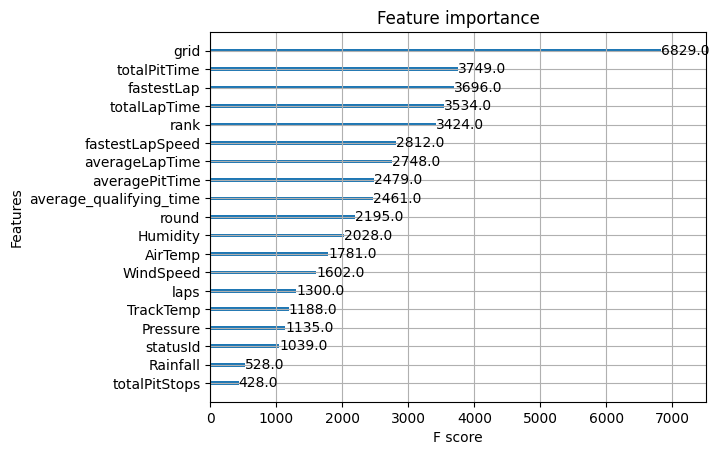

In [23]:
xgb.plot_importance(model)
plt.show()

## Prediction based on weather


In [24]:
final_dataframe = pd.read_csv('final_dataframe.csv')
loaded_model = xgb.Booster()
loaded_model.load_model('xgb_model.model')  # Load your saved model

In [25]:
# Create sliders for weather features
rainfall_slider = widgets.FloatSlider(min=0, max=10, step=0.1, description='Rainfall (mm)')
air_temp_slider = widgets.FloatSlider(min=-50, max=50, step=1, description='Air Temperature (°C)')
humidity_slider = widgets.FloatSlider(min=0, max=100, step=1, description='Humidity (%)')

driver_dropdown = widgets.Dropdown(
    options=[(driver_name_lookup.get(driver_id, 'Unknown Driver'), driver_id)
             for driver_id in final_dataframe['driverId'].unique()],
    description='Driver:'
)

circuit_dropdown = widgets.Dropdown(
    options=[(circuit_name_lookup.get(circuit_id, 'Unknown Circuit'), circuit_id) for circuit_id in final_dataframe['circuitId'].unique()],
    description='Circuit:'
)

In [26]:
def predict_for_driver_circuit(driver_id, circuit_id, air_temp, humidity, rainfall, data=data):
    """Predicts position for a specific driver and circuit with weather conditions."""
    # Filter data for driver and circuit
    driver_circuit_data = data[
        (data['driverId'] == driver_id) &
        (data['circuitId'] == circuit_id)
    ]

    # Check if the DataFrame is empty
    if driver_circuit_data.empty:
        return "No data available for this driver-circuit combination."  # Or a default value like -1

    # Override weather features with slider values
    driver_circuit_data.loc[:, 'AirTemp'] = air_temp
    driver_circuit_data.loc[:, 'Humidity'] = humidity
    driver_circuit_data.loc[:, 'Rainfall'] = rainfall

    # Drop unnecessary columns
    driver_circuit_data = driver_circuit_data.drop(columns=['positionOrder', 'Year'] + exclude_cols)

    # Impute using the previously fitted imputer
    # driver_circuit_data = imputer.transform(driver_circuit_data)

    # Make prediction
    dpred = xgb.DMatrix(driver_circuit_data)
    prediction = model.predict(dpred)

    return prediction[0]

In [27]:
# Create an output widget to display the prediction
output = widgets.Output()

# Define a function to update the output when sliders change
def update_prediction(change):
    with output:
        output.clear_output()
        # clear_output(wait=True)
        if isinstance(driver_dropdown.value, tuple):
            selected_driver_name, selected_driver_id = driver_dropdown.value
            selected_circuit_name, selected_circuit_id = circuit_dropdown.value
        else:
            selected_driver_name = driver_name_lookup.get(driver_dropdown.value, 'Unknown Driver')
            selected_driver_id = driver_dropdown.value  # Assuming value is the
            selected_circuit_name = circuit_name_lookup.get(circuit_dropdown.value, 'Unknown Circuit')
            selected_circuit_id = circuit_dropdown.value

        prediction = predict_for_driver_circuit(
            selected_driver_id,  # Get driver ID from dropdown
            selected_circuit_id, # Get circuit ID from dropdown (assuming you have a circuit dropdown)
            air_temp_slider.value,
            humidity_slider.value,
            rainfall_slider.value
        )

        if isinstance(prediction, str):
            print(prediction)
        else:
            print(f"Predicted position for {selected_driver_name} at {selected_circuit_name}: {prediction:.0f}")



In [28]:
# Create a button
force_plot_button = widgets.Button(description="Generate Force Plot")

# Define a function to generate and display the force plot
def on_force_plot_button_clicked(b):
    with output:
        clear_output()

        # Get selected driver and circuit IDs
        selected_driver_id = driver_dropdown.value[1] if isinstance(driver_dropdown.value, tuple) else driver_dropdown.value
        selected_circuit_id = circuit_dropdown.value[1] if isinstance(circuit_dropdown.value, tuple) else circuit_dropdown.value

        # Filter data for driver and circuit
        driver_circuit_data = data[
            (data['driverId'] == selected_driver_id) &
            (data['circuitId'] == selected_circuit_id)
        ]

        # Check if the DataFrame is empty
        if driver_circuit_data.empty:
            print("No data available for this driver-circuit combination.")
            return

        # Override weather features with slider values
        driver_circuit_data.loc[:, 'AirTemp'] = air_temp_slider.value
        driver_circuit_data.loc[:, 'Humidity'] = humidity_slider.value
        driver_circuit_data.loc[:, 'Rainfall'] = rainfall_slider.value

        # Drop unnecessary columns
        driver_circuit_data = driver_circuit_data.drop(columns=['positionOrder', 'Year'] + exclude_cols)

        # Create a SHAP explainer
        explainer = shap.TreeExplainer(model)

        # Calculate SHAP values for the specific instance
        shap_values = explainer.shap_values(driver_circuit_data)

        # Display the force plot
        shap.initjs()  # Initialize JavaScript for SHAP plots
        shap.force_plot(explainer.expected_value, shap_values[0], driver_circuit_data.iloc[0], matplotlib=True, show=False)
        plt.show()




In [76]:
interactive_scatter_button = widgets.Button(description="Generate Scatter Plot")

# Create a function to update the scatter plot
def update_scatter_plot(change):  # The 'change' argument is needed for button click events
    with output:
        clear_output(wait=True)  # Clear previous output

        # Get the selected circuit ID from the dropdown
        selected_circuit_id = circuit_dropdown.value[1] if isinstance(circuit_dropdown.value, tuple) else circuit_dropdown.value

        # Filter the data for the selected circuit
        filtered_data = data[data['circuitId'] == selected_circuit_id].copy()

        # Add driver names to filtered data for hover data
        filtered_data.loc[:,'driver_name'] = filtered_data['driverId'].map(driver_name_lookup)

        # Get predictions for all drivers in the filtered data
        predictions = []
        for driver_id in filtered_data['driverId'].unique():
            prediction = predict_for_driver_circuit(
                driver_id, selected_circuit_id, air_temp_slider.value, humidity_slider.value, rainfall_slider.value
            )
            predictions.append({'driverId': driver_id, 'predicted_position': prediction})

        # Create a DataFrame with predictions
        predictions_df = pd.DataFrame(predictions)

        # Merge predictions with filtered data
        filtered_data = pd.merge(filtered_data, predictions_df, on='driverId', how='left')


        # Create the scatter plot
        fig = px.scatter(
            filtered_data,
            x="grid",
            y="predicted_position",
            color="totalPitTime",
             hover_data={
                "driverId": False,  # Hide the raw driverId from hover data
                "driver_name": True, # Include driver name in hover data
                'predicted_position': True, # Include predicted position in hover data
            },
            custom_data=['driver_name', 'predicted_position'], # customdata for hovertemplate
            labels={"grid": "Qualifying Position", "positionOrder": "Finishing Position"},
            title=f"Qualifying vs. Predicted Finishing Position for {circuit_name_lookup.get(selected_circuit_id, 'Unknown Circuit')}"  # Dynamic title
        )

        # Customize the plot (optional)
        fig.update_traces(marker=dict(size=10),
                          hovertemplate="<b>Driver:</b> %{customdata[0]}<br>" +
                                        "<b>Predicted Position:</b> %{customdata[1]:.0f}<br>"
        )

        fig.update_layout(
            xaxis_title="Qualifying Position",
            yaxis_title="Finishing Position",
            legend_title="Driver ID",
        )

        fig.show()

In [77]:
# Observe slider changes and trigger the update function
rainfall_slider.observe(update_prediction, names='value')
air_temp_slider.observe(update_prediction, names='value')
humidity_slider.observe(update_prediction, names='value')
driver_dropdown.observe(update_prediction, names='value')
circuit_dropdown.observe(update_prediction, names='value')

# Attach the function to the button's click event
force_plot_button.on_click(on_force_plot_button_clicked)

# Attach the function to the button's click event
interactive_scatter_button.on_click(update_scatter_plot)

# Display the widgets and output
display(widgets.VBox([rainfall_slider, air_temp_slider, humidity_slider, circuit_dropdown, driver_dropdown, force_plot_button, interactive_scatter_button, output]))